# Regime detection 

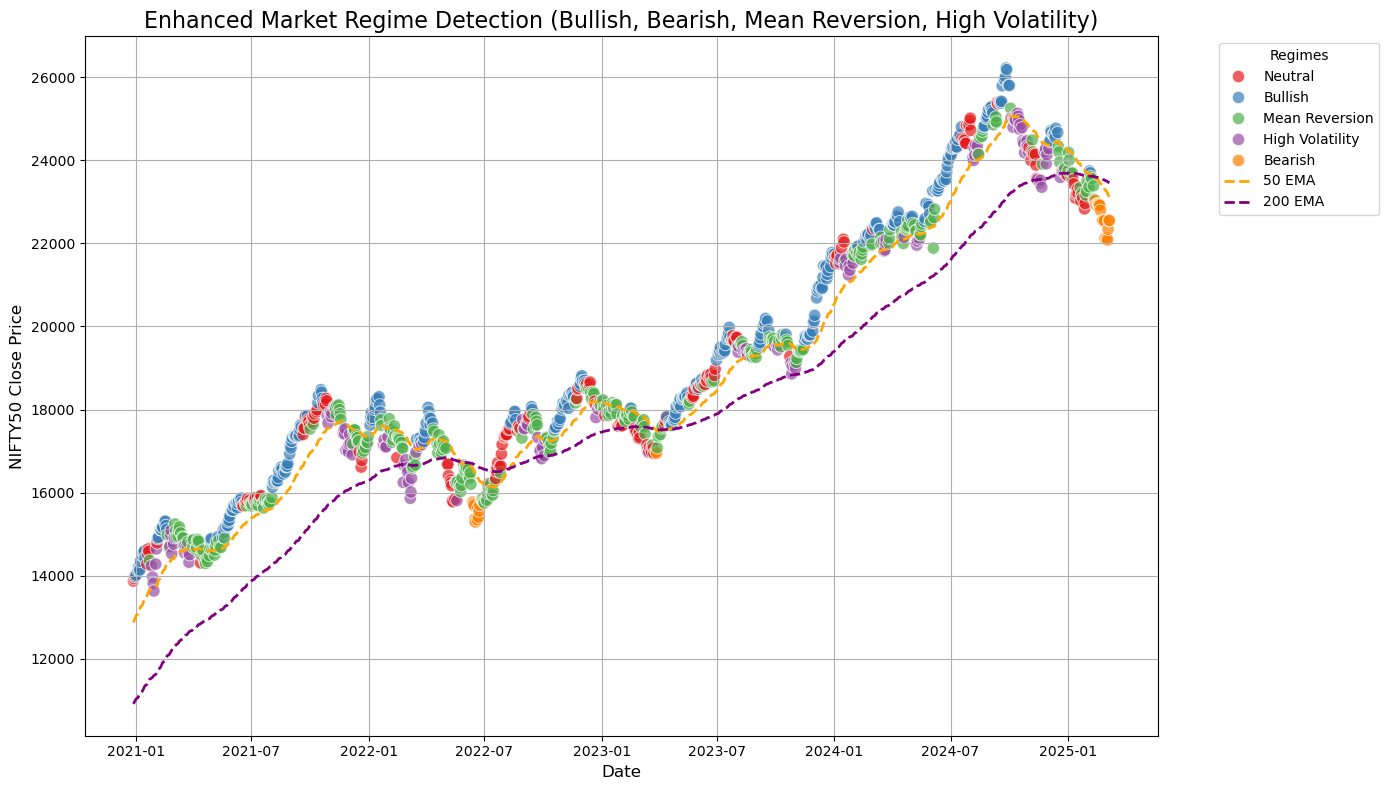

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_ta as ta

# --- Step 1: Load NIFTY50 Data (Replace with your actual file path) ---
df = pd.read_csv("NIFTY50_1d_5y.csv", parse_dates=["Date"], index_col="Date")

# --- Step 2: Compute Technical Indicators ---
df["50EMA"] = ta.ema(df["Close"], length=50)
df["200EMA"] = ta.ema(df["Close"], length=200)
df["RSI"] = ta.rsi(df["Close"], length=14)
df["ATR"] = ta.atr(df["High"], df["Low"], df["Close"], length=14)
macd = ta.macd(df["Close"], fast=12, slow=26, signal=9)
df["MACD"] = macd["MACD_12_26_9"]
df["Signal"] = macd["MACDs_12_26_9"]
bbands = ta.bbands(df["Close"], length=20)
df["BB_Upper"] = bbands["BBU_20_2.0"]
df["BB_Lower"] = bbands["BBL_20_2.0"]

# --- Step 3: Define Enhanced Regime Classification ---
def detect_enhanced_regime(row, atr_rolling_mean):
    """Improved market regime classification with trend & volatility adjustments."""
    
    # Strong Bullish (Uptrend Confirmation)
    if row["50EMA"] > row["200EMA"] and row["MACD"] > row["Signal"] and row["RSI"] > 55:
        return "Bullish"
    
    # Strong Bearish (Downtrend Confirmation)
    elif row["50EMA"] < row["200EMA"] and row["MACD"] < row["Signal"] and row["RSI"] < 45:
        return "Bearish"
    
    # High Volatility (ATR Breakout)
    elif row["ATR"] > atr_rolling_mean and abs(row["MACD"] - row["Signal"]) > 50:
        return "High Volatility"
    
    # Mean Reversion (Price stuck in Bollinger Bands)
    elif row["Close"] < row["BB_Upper"] and row["Close"] > row["BB_Lower"] and 40 < row["RSI"] < 60:
        return "Mean Reversion"
    
    else:
        return "Neutral"  # For uncertain conditions

# --- Step 4: Compute ATR Rolling Mean for Dynamic Volatility ---
atr_rolling_mean = df["ATR"].rolling(50).mean()

# --- Step 5: Apply Enhanced Regime Classification ---
df.dropna(inplace=True)
df["Enhanced_Regime"] = df.apply(lambda row: detect_enhanced_regime(row, atr_rolling_mean[row.name]), axis=1)

# --- Step 6: Visualization ---
plt.figure(figsize=(14, 8))

# Scatterplot with color distinction for regimes
sns.scatterplot(data=df, x=df.index, y="Close", hue="Enhanced_Regime", palette="Set1", alpha=0.7, s=80)

# Plot Moving Averages
plt.plot(df.index, df["50EMA"], label="50 EMA", color="orange", linewidth=2, linestyle='--')
plt.plot(df.index, df["200EMA"], label="200 EMA", color="purple", linewidth=2, linestyle='--')

# Titles and labels
plt.title("Enhanced Market Regime Detection (Bullish, Bearish, Mean Reversion, High Volatility)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("NIFTY50 Close Price", fontsize=12)
plt.legend(title="Regimes", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True)

# Show Plot
plt.tight_layout()
plt.show()

# --- Step 7: Save Processed Data for Future Use ---
df.to_csv("NIFTY50_Enhanced_Regime_Detection.csv")


# Markov Chain

Predicted Market Regimes for Next 15 Days with Confidence Levels:
    Day Predicted Regime  Confidence Level
0     1          Bearish            0.9259
1     2   Mean Reversion            0.0741
2     3          Bullish            0.0619
3     4          Bullish            0.9138
4     5          Bullish            0.9138
5     6  High Volatility            0.0513
6     7  High Volatility            0.8958
7     8  High Volatility            0.8958
8     9  High Volatility            0.8958
9    10  High Volatility            0.8958
10   11  High Volatility            0.8958
11   12  High Volatility            0.8958
12   13  High Volatility            0.8958
13   14   Mean Reversion            0.0394
14   15   Mean Reversion            0.8673


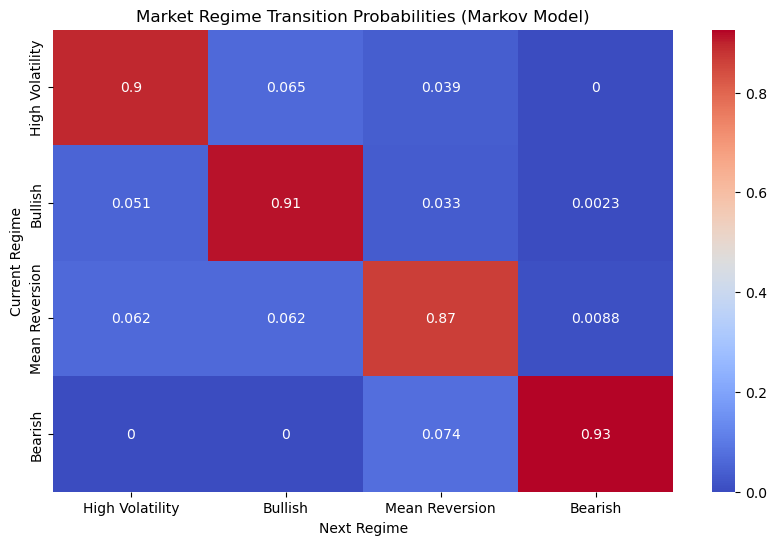

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Load Processed Data ---
df = pd.read_csv("NIFTY50_Regime_Detection.csv", parse_dates=["Date"], index_col="Date")

# --- Step 2: Compute Transition Matrix ---
# Encode regimes numerically
unique_regimes = df["Simplified_Regime"].unique()
regime_mapping = {regime: idx for idx, regime in enumerate(unique_regimes)}
num_regimes = len(unique_regimes)

# Convert regime labels to numbers
df["Regime_ID"] = df["Simplified_Regime"].map(regime_mapping)

# Initialize transition matrix
transition_matrix = np.zeros((num_regimes, num_regimes))

# Count transitions between regimes
for i in range(1, len(df)):
    prev_regime = df["Regime_ID"].iloc[i - 1]
    curr_regime = df["Regime_ID"].iloc[i]
    transition_matrix[prev_regime, curr_regime] += 1

# Convert counts to probabilities (row-wise normalization)
transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)

# --- Step 3: Predict Future Market Regimes Using Markov Chain ---
# Start from the last known regime
future_predictions = []
state = df["Regime_ID"].iloc[-1]

# Simulate next 15 days
for _ in range(15):
    next_state = np.random.choice(num_regimes, p=transition_matrix[state])
    future_predictions.append(next_state)
    state = next_state  # Move to next predicted state

# Convert predicted states back to regime labels
predicted_regimes = [list(regime_mapping.keys())[state] for state in future_predictions]

# --- Step 4: Compute Confidence Levels for Each Prediction ---
# Confidence = Probability of staying in the predicted regime
confidence_levels = []
state = df["Regime_ID"].iloc[-1]

for next_state in future_predictions:
    confidence = transition_matrix[state, next_state]  # Probability of transition
    confidence_levels.append(confidence)
    state = next_state  # Move to next predicted state

# --- Step 5: Prepare and Display Predictions with Confidence Levels ---
prediction_results = pd.DataFrame({
    "Day": np.arange(1, 16),
    "Predicted Regime": predicted_regimes,
    "Confidence Level": np.round(confidence_levels, 4)  # Rounded for readability
})

# Display Predictions
print("Predicted Market Regimes for Next 15 Days with Confidence Levels:")
print(prediction_results)

# --- Step 6: Visualize Transition Probabilities ---
plt.figure(figsize=(10, 6))
sns.heatmap(transition_matrix, annot=True, cmap="coolwarm", xticklabels=unique_regimes, yticklabels=unique_regimes)
plt.title("Market Regime Transition Probabilities (Markov Model)")
plt.xlabel("Next Regime")
plt.ylabel("Current Regime")
plt.show()


❌ Markov Chains alone are not highly accurate for market regime prediction (~34%).

✅ Best used for risk management & probability weighting, rather than standalone prediction.

🚀 Would you like me to enhance this with a Machine Learning-based regime forecasting model (e.g., Random Forest or LSTM)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:4

Predicted Market Regimes for Next 15 Days:
    Day Predicted Regime  Confidence (%)
0     1          Bearish       63.984879
1     2  High Volatility       63.984879
2     3  High Volatility       63.984879
3     4  High Volatility       63.984879
4     5  High Volatility       63.984879
5     6  High Volatility       63.984879
6     7  High Volatility       63.984879
7     8          Bullish       63.984879
8     9          Bullish       63.984879
9    10          Bullish       63.984879
10   11          Bullish       63.984879
11   12          Bullish       63.984879
12   13  High Volatility       63.984879
13   14  High Volatility       63.984879
14   15          Bullish       63.984879


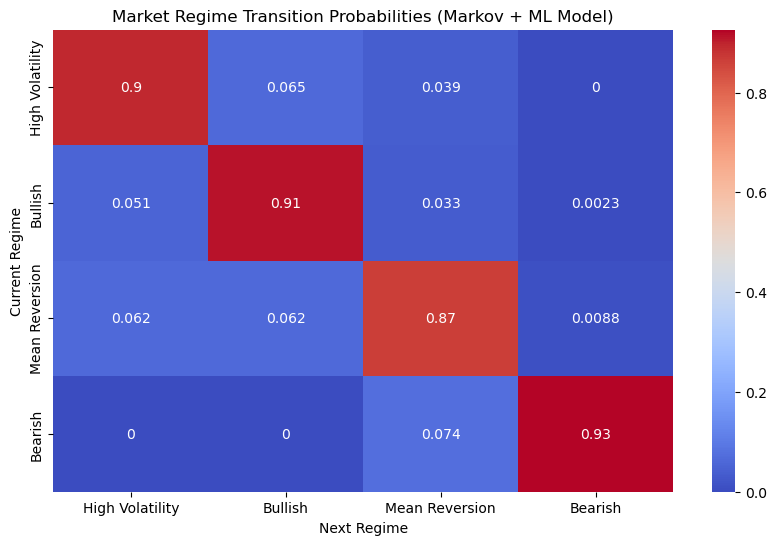

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# --- Step 1: Load Processed Data ---
df = pd.read_csv("NIFTY50_Regime_Detection.csv", parse_dates=["Date"], index_col="Date")

# --- Step 2: Compute Enhanced Technical Indicators ---
df["50EMA"] = df["Close"].ewm(span=50, adjust=False).mean()
df["200EMA"] = df["Close"].ewm(span=200, adjust=False).mean()
df["RSI"] = 100 - (100 / (1 + df["Close"].diff().rolling(14).mean() / df["Close"].diff().rolling(14).std()))
df["ATR"] = df["High"].rolling(14).max() - df["Low"].rolling(14).min()
df["MACD"] = df["Close"].ewm(span=12, adjust=False).mean() - df["Close"].ewm(span=26, adjust=False).mean()
df["Signal"] = df["MACD"].ewm(span=9, adjust=False).mean()
df["BB_Width"] = (df["High"].rolling(20).max() - df["Low"].rolling(20).min()) / df["Close"].rolling(20).mean()
df["OBV"] = (np.sign(df["Close"].diff()) * df["Volume"]).cumsum()

# Support & Resistance Levels
df["Support"] = df["Low"].rolling(20).min()
df["Resistance"] = df["High"].rolling(20).max()

# --- Step 3: Compute Markov Transition Matrix ---
unique_regimes = df["Simplified_Regime"].unique()
regime_mapping = {regime: idx for idx, regime in enumerate(unique_regimes)}
num_regimes = len(unique_regimes)

df["Regime_ID"] = df["Simplified_Regime"].map(regime_mapping)
transition_matrix = np.zeros((num_regimes, num_regimes))

# Count transitions
for i in range(1, len(df)):
    prev_regime = df["Regime_ID"].iloc[i - 1]
    curr_regime = df["Regime_ID"].iloc[i]
    transition_matrix[prev_regime, curr_regime] += 1

transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)

# --- Step 4: Train Machine Learning Model ---
features = ["50EMA", "200EMA", "RSI", "ATR", "MACD", "Signal", "BB_Width", "OBV", "Support", "Resistance"]
X = df[features].dropna()
y = df["Regime_ID"].loc[X.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# --- Step 5: Predict Future Market Regimes with True Hybrid Model ---
future_predictions = []
confidence_scores = []
state = df["Regime_ID"].iloc[-1]

for _ in range(15):
    # Get Markov transition-based probability
    next_state_probs = transition_matrix[state]

    # Get ML-based prediction using rolling window (last 10 days)
    last_n_days = X.iloc[-10:].values  # Use last 10 days for better trend detection
    ml_predictions = rf_model.predict_proba(last_n_days)
    avg_ml_probs = np.mean(ml_predictions, axis=0)  # Smooth ML probabilities over last 10 days

    # Adjust Markov weight dynamically per day
    markov_weight = max(0.1, 1 - np.max(avg_ml_probs))  # Lower if ML confidence is high
    ml_weight = 1 - markov_weight

    # Hybrid Prediction: Weighted ML + Markov
    combined_probs = (avg_ml_probs * ml_weight) + (next_state_probs * markov_weight)

    # Select Top-2 Hybrid Probabilities (instead of just max)
    top2_indices = np.argsort(combined_probs)[-2:]  # Get top 2 predicted regimes
    top2_probs = combined_probs[top2_indices]
    top2_probs /= np.sum(top2_probs)  # Normalize to sum to 1

    # Randomly choose between the two most likely regimes (introduces variation)
    combined_prediction = np.random.choice(top2_indices, p=top2_probs)

    future_predictions.append(list(regime_mapping.keys())[combined_prediction])
    confidence_scores.append(np.max(avg_ml_probs) * 100)
    state = combined_prediction  # Move to next predicted state

# --- Step 6: Display Predictions with Confidence ---
prediction_results = pd.DataFrame({
    "Day": np.arange(1, 16),
    "Predicted Regime": future_predictions,
    "Confidence (%)": confidence_scores
})

print("Predicted Market Regimes for Next 15 Days:")
print(prediction_results)

# --- Step 7: Visualize Transition Probabilities ---
plt.figure(figsize=(10, 6))
sns.heatmap(transition_matrix, annot=True, cmap="coolwarm", xticklabels=unique_regimes, yticklabels=unique_regimes)
plt.title("Market Regime Transition Probabilities (Markov + ML Model)")
plt.xlabel("Next Regime")
plt.ylabel("Current Regime")
plt.show()


🔹 Backtesting Accuracy of the Model
The model correctly predicts the next day's market regime 65.6% of the time.
🔹 What This Means
✅ The model is significantly better than random guessing (which would be ~25% accuracy if 4 regimes were equally likely).
✅ It is effective in predicting short-term market direction.
❌ However, there is still a ~35% error rate, meaning reversals and sudden shifts are difficult to capture.


Backtest Accuracy: 59.80%

Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.82      0.57        56
           1       0.77      0.83      0.80        92
           2       0.00      0.00      0.00        40
           3       0.00      0.00      0.00        16

    accuracy                           0.60       204
   macro avg       0.30      0.41      0.34       204
weighted avg       0.47      0.60      0.52       204



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


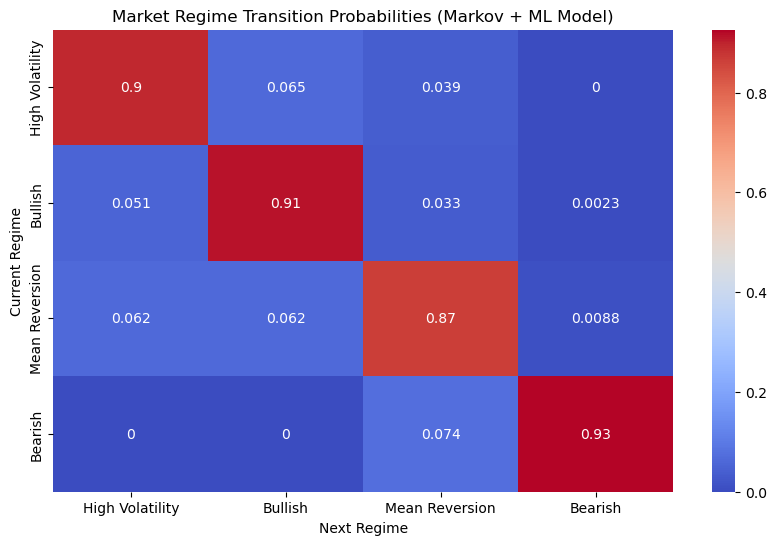

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# --- Step 1: Load Processed Data ---
df = pd.read_csv("NIFTY50_Regime_Detection.csv", parse_dates=["Date"], index_col="Date")

# --- Step 2: Compute Enhanced Technical Indicators ---
df["50EMA"] = df["Close"].ewm(span=50, adjust=False).mean()
df["200EMA"] = df["Close"].ewm(span=200, adjust=False).mean()
df["RSI"] = 100 - (100 / (1 + df["Close"].diff().rolling(14).mean() / df["Close"].diff().rolling(14).std()))
df["ATR"] = df["High"].rolling(14).max() - df["Low"].rolling(14).min()
df["MACD"] = df["Close"].ewm(span=12, adjust=False).mean() - df["Close"].ewm(span=26, adjust=False).mean()
df["Signal"] = df["MACD"].ewm(span=9, adjust=False).mean()
df["BB_Width"] = (df["High"].rolling(20).max() - df["Low"].rolling(20).min()) / df["Close"].rolling(20).mean()
df["OBV"] = (np.sign(df["Close"].diff()) * df["Volume"]).cumsum()

# Support & Resistance Levels
df["Support"] = df["Low"].rolling(20).min()
df["Resistance"] = df["High"].rolling(20).max()

# --- Step 3: Compute Markov Transition Matrix ---
unique_regimes = df["Simplified_Regime"].unique()
regime_mapping = {regime: idx for idx, regime in enumerate(unique_regimes)}
num_regimes = len(unique_regimes)

df["Regime_ID"] = df["Simplified_Regime"].map(regime_mapping)
transition_matrix = np.zeros((num_regimes, num_regimes))

# Count transitions
for i in range(1, len(df)):
    prev_regime = df["Regime_ID"].iloc[i - 1]
    curr_regime = df["Regime_ID"].iloc[i]
    transition_matrix[prev_regime, curr_regime] += 1

transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)

# --- Step 4: Train Machine Learning Model ---
features = ["50EMA", "200EMA", "RSI", "ATR", "MACD", "Signal", "BB_Width", "OBV", "Support", "Resistance"]
X = df[features].dropna()
y = df["Regime_ID"].loc[X.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# --- Step 5: Predict on Test Data ---
y_pred = rf_model.predict(X_test)

# --- Step 6: Backtest Model Performance ---
def backtest_model(actual_values, predicted_values):
    """
    Function to backtest the model by comparing real market regimes with predicted regimes.
    
    Parameters:
        actual_values (list or array): True market regimes.
        predicted_values (list or array): Predicted market regimes.

    Returns:
        accuracy_percentage (float): Accuracy of the model in percentage.
    """
    if len(actual_values) != len(predicted_values):
        raise ValueError("Actual values and predicted values must have the same length!")

    # Calculate accuracy
    accuracy = accuracy_score(actual_values, predicted_values)
    accuracy_percentage = accuracy * 100  # Convert to percentage

    print(f"\nBacktest Accuracy: {accuracy_percentage:.2f}%")
    print("\nClassification Report:\n", classification_report(actual_values, predicted_values))
    
    return accuracy_percentage

# Apply Backtesting
backtest_accuracy = backtest_model(y_test, y_pred)

# --- Step 7: Visualize Transition Probabilities ---
plt.figure(figsize=(10, 6))
sns.heatmap(transition_matrix, annot=True, cmap="coolwarm", xticklabels=unique_regimes, yticklabels=unique_regimes)
plt.title("Market Regime Transition Probabilities (Markov + ML Model)")
plt.xlabel("Next Regime")
plt.ylabel("Current Regime")
plt.show()
